In [284]:
import tensorflow as tf

In [285]:
# Get a list of physical devices visible to the host runtime
device_type = "GPU"  # The device type
devices = tf.config.list_physical_devices(device_type)

if not devices:
    # Raise an informative message when there are no devices in the host runtime
    raise RuntimeError(f"No {device_type} devices are used in the host.")

In [286]:
seed = 27912

In [287]:
from pathlib import Path
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [288]:
!pip install split-folders
import splitfolders

In [289]:
import pandas as pd
import os
import shutil

In [290]:
if os.path.exists("/kaggle/working/data_aumentation"):
    shutil.rmtree("/kaggle/working/data_aumentation")

In [291]:
splitfolders.ratio("/kaggle/input/fruit-dataset-v2/Dataset Fruits/train", 
                   output="/kaggle/working/data_aumentation", 
                   seed=seed, 
                   ratio=(.8, .2), 
                   group_prefix=None, 
                   move=False
                  )
# splitfolders.ratio("/kaggle/input/fruit-dataset/Dataset Fruits/test", 
#                    output="/kaggle/working/data_aumentation", 
#                    seed=seed, 
#                    ratio=(.8, .2), 
#                    group_prefix=None, 
#                    move=False
#                   )

Copying files: 3100 files [00:04, 660.01 files/s]


In [292]:
import matplotlib.pyplot as plt
import numpy as np

In [293]:
competition = "fruit-dataset-v2"  # The unique name of the competition
root = Path("..") / "input" / competition  # Directory with the subsets of the data

directory = "/kaggle/working/data_aumentation/train"
batch_size = 32  # Size of the batches of data
image_size = (256, 256)  # Size to resize images to after they are read from disk
class_mode = "sparse"

# Generate the training dataset from image files in the corresponding directory
train = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)

Found 2478 files belonging to 11 classes.


In [294]:
directory = "/kaggle/working/data_aumentation/val"

# Generate the validation dataset from image files in the corresponding directory
validation = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, seed = seed)

Found 622 files belonging to 11 classes.


In [295]:
# directory = Path(root) / "test"
directory = "/kaggle/input/fruit-dataset-v2/Dataset Fruits/test"
shuffle = False  # Whether to shuffle the data

# Generate the testing dataset from image files in the corresponding directory
test = keras.utils.image_dataset_from_directory(directory, batch_size = batch_size, image_size = image_size, shuffle = shuffle)

Found 48 files belonging to 1 classes.


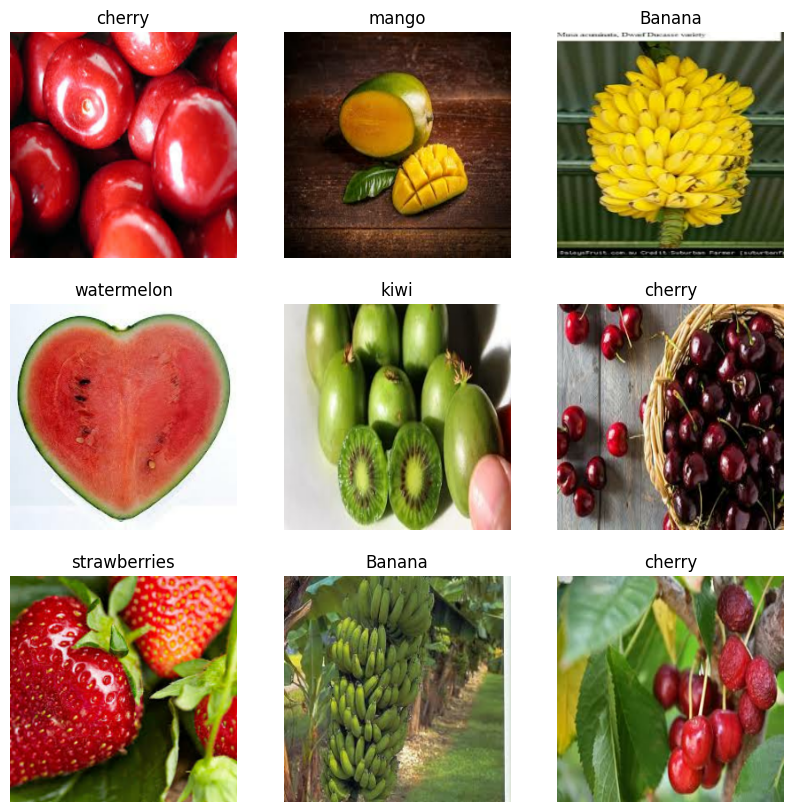

In [296]:
# Create a new figure
num = None  # A unique identifier for the figure
figsize = (10, 10)  # Width and height in inches
plt.figure(num, figsize)

# Create a dataset with one element
tensors = train.take(1)

# Get the class names from the training dataset
classes = train.class_names
classes = np.array(classes)
# classes = train.class_indices
# classes = np.array(list(classes))


for images, labels in tensors:
    for i in range(9):
        # Transform the tensor to an array
        image = images[i]
        dtype = np.uint8  # Typecode to which the array is cast
        image = np.array(image).astype(dtype)

        # Get the class name of the image
        label = labels[i]
        label = classes[label]

        # Visualize the image
        rows = 3
        columns = 3
        index = i + 1
        option = "off"  # Hide all axis decorations
        ax = plt.subplot(rows, columns, index)
        plt.imshow(image)
        plt.title(label)
        plt.axis(option)

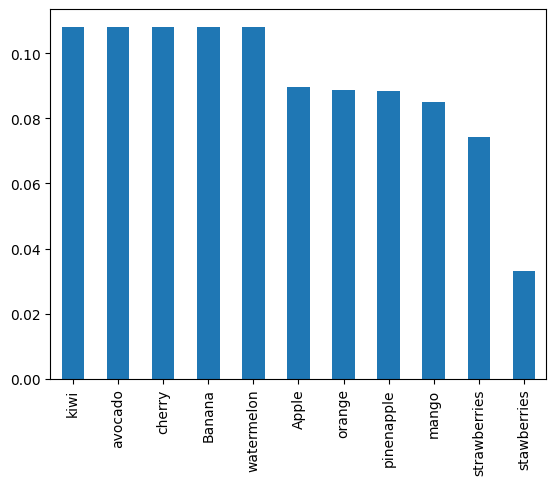

In [297]:
function = lambda file: file.split(os.sep)[5]
iterable = train.file_paths
generator = map(function, iterable)

data = list(generator)  # Data to be stored
normalize = True  # Return the relative frequencies of the unique values
sort = True  # Sort by frequencies
kind = "bar"  # The kind of plot to produce

pd.Series(data).value_counts(normalize, sort).plot(kind = kind);

In [298]:
from collections import defaultdict

In [299]:
models = defaultdict(dict)

In [300]:
data_augmentation = keras.models.Sequential(
    [
        keras.layers.RandomFlip("horizontal"), 
        keras.layers.RandomRotation(0.1), 
        keras.layers.RandomZoom(0.2),
    ]
)

In [301]:
scale = 1 / 255  # The scale to apply to the inputs.
input_shape = (*image_size, 3)  # Arbitrary

In [302]:
data_format = "channels_last"  # The ordering of the dimensions in the inputs

In [303]:
units = 64  # Dimensionality of the output space
activation = "relu"  # Activation function

In [304]:
units = len(classes)
activation = "softmax"

In [305]:
length = 79  # Total length of printed lines

In [306]:
lr = 0.001  #  The learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)  # Optimizer instance
loss = "sparse_categorical_crossentropy"  # Loss function
metrics = ["accuracy"]  # List of metrics to be evaluated by the model during training and testing

In [307]:
include_top = False  # Whether to include the layers at the top of the network
weights = "imagenet"  # The weights to use for the network

models["Transfer learning"]["model"] = tf.keras.applications.Xception(include_top, weights, input_shape = input_shape)

In [308]:
models["Transfer learning"]["model"].trainable = False

In [309]:
inputs = models["Transfer learning"]["model"].input

x = models["Transfer learning"]["model"].output

In [310]:
x = keras.layers.Flatten(data_format)(x)

In [311]:
units = 1024
activation = "relu"
# x = keras.layers.Dense(units, activation)(x)
# x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units, activation)(x)
x = keras.layers.Dropout(0.5)(x)


units = len(classes)
activation = "softmax"
x = keras.layers.Dense(units, activation)(x)

In [312]:
# inputs = models["Transfer learning"]["model"].input
outputs = x

models["Transfer learning"]["model"] = keras.Model(inputs, outputs)
# models["Transfer learning"]["model"].summary(length)

In [313]:
lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
models["Transfer learning"]["model"].compile(optimizer, loss, metrics)

In [314]:
include_top = False  # Whether to include the layers at the top of the network
weights = "imagenet"  # The weights to use for the network

models["Transfer learning Road 0.99"]["model"] = tf.keras.applications.EfficientNetV2B0(include_top, weights, input_shape = input_shape)

models["Transfer learning Road 0.99"]["model"].trainable = False

inputs = models["Transfer learning Road 0.99"]["model"].input

x = models["Transfer learning Road 0.99"]["model"].output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten(data_format)(x)

units = 1024
activation = "relu"


x = keras.layers.Dense(units, activation)(x)
x = keras.layers.Dropout(0.5)(x)


units = len(classes)
activation = "softmax"
x = keras.layers.Dense(units, activation)(x)

outputs = x

models["Transfer learning Road 0.99"]["model"] = keras.Model(inputs, outputs)
# models["Transfer learning"]["model"].summary(length)

lr = 0.0004
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

models["Transfer learning Road 0.99"]["model"].compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

In [315]:
epochs = 35

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="Transfer learning Road 0.99.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5
    )
]

models["Transfer learning Road 0.99"]["history"] = models["Transfer learning Road 0.99"]["model"].fit(
    x=train,
    validation_data=validation,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 301ms/step - accuracy: 0.6232 - loss: 1.3084 - val_accuracy: 0.8923 - val_loss: 0.3156
Epoch 2/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9070 - loss: 0.2917 - val_accuracy: 0.9212 - val_loss: 0.2457
Epoch 3/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9253 - loss: 0.2185 - val_accuracy: 0.9244 - val_loss: 0.2233
Epoch 4/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9409 - loss: 0.1783 - val_accuracy: 0.9228 - val_loss: 0.2214
Epoch 5/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.9461 - loss: 0.1648 - val_accuracy: 0.9277 - val_loss: 0.2182
Epoch 6/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9539 - loss: 0.1409 - val_accuracy: 0.9277 - val_loss: 0.2197
Epoch 7/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.9532 - loss: 0.1349 - val_accuracy: 0.9309 - val_loss: 0.2078
Epoch 8/35
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9629 - loss: 0.1138 - val_accuracy: 0.9373 -

In [316]:
file_path = "/kaggle/working/Transfer learning Road 0.99.keras"
models["Fine Tuning"]["model"] = tf.keras.models.load_model(file_path)
models["Best Model"]["model"] = tf.keras.models.load_model(file_path)

In [319]:
for layer in models["Fine Tuning"]["model"].layers:
    if not isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True
        
        
lr = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# models["Fine Tuning"]["model"].compile(optimizer_fine_tuning, loss, metrics)

models["Fine Tuning"]["model"].compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)


In [320]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="Fine Tuning.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode="max"
    ),        
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10,
        restore_best_weights=True
    )
]

epochs = 30

models["Fine Tuning"]["history"] = models["Fine Tuning"]["model"].fit(
    x=train, 
    validation_data=validation, 
    epochs=epochs, 
    callbacks=callbacks
)


Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 88s 461ms/step - accuracy: 0.9565 - loss: 0.1214 - val_accuracy: 0.9277 - val_loss: 0.2180
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9692 - loss: 0.0870 - val_accuracy: 0.9357 - val_loss: 0.2006
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.9750 - loss: 0.0601 - val_accuracy: 0.9260 - val_loss: 0.1924
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 0.9686 - loss: 0.0762 - val_accuracy: 0.9309 - val_loss: 0.1996
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9854 - loss: 0.0422 - val_accuracy: 0.9341 - val_loss: 0.2157
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.9817 - loss: 0.0469 - val_accuracy: 0.9309 - val_loss: 0.2103
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 154ms/step - accuracy: 0.9869 - loss: 0.0324 - val_accuracy: 0.9389 - val_loss: 0.1871
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 150ms/step - accuracy: 0.9924 - loss: 0.0270 - val_accu

In [321]:
file_path = "/kaggle/working/Fine Tuning.keras"
models["Best Tuning"]["model"] = tf.keras.models.load_model(file_path)

In [322]:
%%capture
pip install plot_keras_history

In [323]:
from plot_keras_history import plot_history

In [324]:
for model in models:
    # Plot the model training history
    history = models[model]["history"]
    plot_history(history)

KeyError: 'history'

In [326]:
def write(model, test, path):
    # Generate output predictions for the input samples
    probabilities = model.predict(test)
    axis = -1  # Index of the axis
    labels = np.argmax(probabilities, axis)
    labels = classes[labels]
    predictions = labels

    # Generate the tabular data with the predictions
    function = lambda path: path.split("/")[-1].split("_")[1].split(".")[0]
    iterable = test.file_paths
    identifiers = map(function, iterable)
    identifiers = list(identifiers)
    data = {"Id": identifiers, "Label": labels}
    submission = pd.DataFrame(data).set_index("Id")
    submission.to_csv(path)

In [327]:
for model in models:
    # Write the predictions to the corresponding output file
    path = str.lower(model).replace(" ", "_") + "_submission.csv"
    model = models[model]["model"]
    write(model, test, path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step


IndexError: list index out of range

In [329]:
for model in models:
    # Save the model to a single file
    path = str.lower(model).replace(" ", "_") + "_model.keras"  # Path where to save the model
    models[model]["model"].save(path)